The first explicit example of nonnegative polynomial that is not a sum of squares was found by Motzkin in 1967. By the [Arithmetic-geometric mean](https://en.wikipedia.org/wiki/Arithmetic%E2%80%93geometric_mean),
$$ \frac{x^4y^2 + x^2y^4 + 1}{3} \ge \sqrt[3]{x^4y^2 \cdot x^2y^4 \cdot 1} = x^2y^2 $$
hence
$$ x^4y^2 + x^2y^4 + 1 - 3x^2y^2 \ge 0. $$
The code belows construct the Motzkin polynomial using [DynamicPolynomials](https://github.com/JuliaAlgebra/DynamicPolynomials.jl).

In [10]:
using DynamicPolynomials
@polyvar x y
motzkin = x^4*y^2 + x^2*y^4 + 1 - 3x^2*y^2

x^4y^2 + x^2y^4 - 3x^2y^2 + 1

The Motzkin polynomial is nonnegative but is not a sum of squares as we can verify numerically as follows.
We first need to pick an SDP solver, see [here](http://www.juliaopt.org/) for a list of the available choices.

In [42]:
using CSDP
solver = CSDPSolver();

In [43]:
using Mosek
solver = MosekSolver();

In [44]:
using SumOfSquares
using JuMP
m = SOSModel(solver = solver)
@constraint m motzkin >= 0 # We constraint `motzkin` to be a sum of squares
solve(m) # Returns the status `:Infeasible`

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 22              
  Cones               

:Infeasible

Even if the Motzkin polynomial is not a sum of squares, it can still be certified to be nonnegative using sums of squares.
Indeed a polynomial is certified to be nonnegative if it is equal to a fraction of sums of squares.
The Motzkin polynomial is equal to a fraction of sums of squares whose denominator is $x^2 + y^2$.
This can be verified numerically as follows:

In [45]:
using SumOfSquares
using JuMP
m = SOSModel(solver = solver)
@constraint m (x^2 + y^2) * motzkin >= 0 # We constraint the `(x^2 + y^2) * motzkin` to be a sum of squares
solve(m) # Returns the status `:Optimal` which means that it is feasible

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 36              
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 36              
  Cones               

:Optimal

One may consider ourself lucky to have had the intuition that $x^2 + y^2$ would work as denominator.
In fact, the search for the denominator can be carried out in parallel to the search of the numerator.
In the example below, we search for a denominator with monomials of degrees from 0 to 2.
If none is found, we can increase the maximum degree 2 to 4, 6, 8, ...
This gives a hierarchy of programs to try in order to certify the nonnegativity of a polynomial by identifying it with a fraction of sum of squares polynomials.
In the case of the Motzkin polynomial we now that degree 2 is enough since $x^2 + y^2$ works.

In [46]:
using SumOfSquares
using PolyJuMP
using JuMP
m = SOSModel(solver = solver)
X = monomials([x, y], 0:2)
# We create a quadratic polynomial that is not necessarily a sum of squares
# since this is implied by the next constraint: `deno >= 1`
@variable m deno Poly(X)
# We want the denominator polynomial to be strictly positive,
# this prevents the trivial solution deno = 0 for instance.
@constraint m deno >= 1
@constraint m deno * motzkin >= 0
solve(m)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45              
  Cones                  : 0               
  Scalar variables       : 6               
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45              
  Cones               

:Optimal

We can check the denominator found by the program using `JuMP.getvalue`

In [47]:
getvalue(deno)

0.8994524919313149x^2 - 8.417376223825856e-11xy + 0.8994524979159756y^2 + 6.987367755126592e-16x - 1.0014392160847468e-15y + 1.9999999943329119

Because a picture is worth a thousand words let's plot the beast.
We can easily extend `Plots` by adding a recipe to plot bivariate polynomials.

In [48]:
using RecipesBase
using MultivariatePolynomials
@recipe function f(x::AbstractVector, y::AbstractVector, p::Polynomial)
    x, y, (x, y) -> p(variables(p) => [x, y])
end

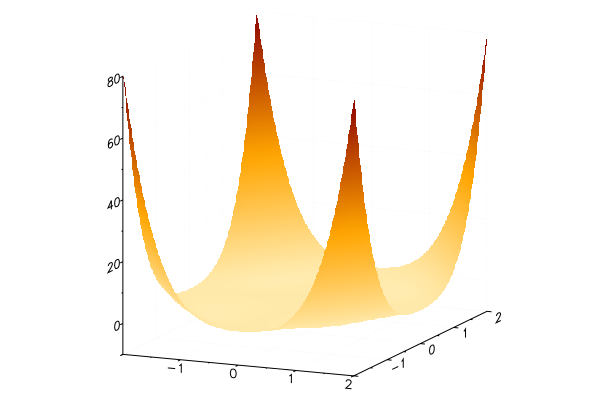

In [49]:
using Plots
plot(linspace(-2, 2, 100), linspace(-2, 2, 100), motzkin, st = [:surface], seriescolor=:heat, colorbar=:none, clims = (-10, 80))